# Libraries and data files

In [ ]:
import csv
import math
import random
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import plotly.express as px
import time
import random
from scipy.stats import beta

In [ ]:
file_id = '17_TZzFAkjQcMVfvOhXt9biAUYcJsSLxi'
url = f'https://drive.google.com/uc?id={file_id}'
#://drive.google.com/file/d/15zTmcxGC9DMQ5Lo0GZLYOoD8-GwXNz87/view?usp=drive_link
output = 'purchases_final.csv'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=17_TZzFAkjQcMVfvOhXt9biAUYcJsSLxi
From (redirected): https://drive.google.com/uc?id=17_TZzFAkjQcMVfvOhXt9biAUYcJsSLxi&confirm=t&uuid=96ff0883-6881-4158-bc12-2f10db0df7ce
To: /content/purchases_final.csv
100%|██████████| 260M/260M [00:01<00:00, 131MB/s]


'purchases_final.csv'

# Simulation

In [ ]:
purchases = pd.read_csv('purchases_final.csv')
purchases.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care


In [ ]:
customers = {
    'Survey ResponseID': purchases['Survey ResponseID'].unique()
}
customers = pd.DataFrame(customers)

## Adding Prime Column

In [ ]:
# add prime column
purchases['Prime'] = 0

from collections import Counter

# amazon prime days from 2018-2022 and amazon prime early access sale 2022
date_ranges = {
    'July 16-17, 2018': ('2018-07-16', '2018-07-17'),
    'July 15-16, 2019': ('2019-07-15', '2019-07-16'),
    'October 13-14, 2020': ('2020-10-13', '2020-10-14'),
    'June 21-22, 2021': ('2021-06-21', '2021-06-22'),
    'July 12-13, 2022': ('2022-07-12', '2022-07-13'),
    'October 11-12, 2022': ('2022-10-11', '2022-10-12')
}

# getting all response ids in the date ranges
id_sets = []
for range_name, (start_date, end_date) in date_ranges.items():
    mask = (purchases['Order Date'] >= start_date) & (purchases['Order Date'] <= end_date)
    distinct_ids = set(purchases[mask]['Survey ResponseID'].unique())
    id_sets.append(distinct_ids)

# response ids that appear in at least 2 events
all_ids = [id for id_set in id_sets for id in id_set]
id_counts = Counter(all_ids)
common_ids = {id for id, count in id_counts.items() if count >= 2}

# make response ids in common_ids as Prime members (Prime = 1)
purchases.loc[purchases['Survey ResponseID'].isin(common_ids), 'Prime'] = 1

print(purchases[purchases['Survey ResponseID'].isin(common_ids)][['Survey ResponseID', 'Prime']].drop_duplicates())

         Survey ResponseID  Prime
607      R_06RZP9pS7kONINr      1
1684     R_0Arj0ePpTnReV1v      1
1800     R_0BCm9hRP9iTI081      1
3000     R_0BWkZUjRId7FDZn      1
3236     R_0D6GtQwa6VcnXpv      1
...                    ...    ...
1527720  R_zTf2i6s3E2OQZQR      1
1528309  R_zYlhkltqLl0WShX      1
1529407  R_zd4E1BgAdaM2761      1
1529925  R_zdLOP8JD2pe1brj      1
1530207  R_zfnsck2ZatnGtY5      1

[1963 rows x 2 columns]


In [ ]:
# total number of unique response ids
total_unique_ids = purchases['Survey ResponseID'].nunique()

# number of unique response ids where Prime = 1
prime_unique_ids = purchases[purchases['Prime'] == 1]['Survey ResponseID'].nunique()

# percentages of unique response ids that are Prime = 1
prime_percentage = (prime_unique_ids / total_unique_ids) * 100
print(f"Percentage of total unique IDs that are prime: {prime_percentage:.2f}%")

Percentage of total unique IDs that are prime: 39.87%


In [ ]:
# total distinct response ids
total_distinct_responses = purchases['Survey ResponseID'].nunique()
print("Total number of distinct Survey Response IDs:", total_distinct_responses)

Total number of distinct Survey Response IDs: 4923


In [ ]:
# 65% of total survey response ids
TOTALCOUNT = int(0.65 * total_distinct_responses)
print("65% of total Survey Response IDs (TOTALCOUNT):", TOTALCOUNT)

65% of total Survey Response IDs (TOTALCOUNT): 3199


In [ ]:
# 39.87% is 1962 people
# We will need:
print(3199-1962)

1237


In [ ]:
# number of additional response ids to set as Prime
additional_needed = 1237

# get response ids that are non-Prime
non_prime_ids = purchases[purchases['Prime'] == 0]['Survey ResponseID'].unique().tolist()

# randomly set 1154 more response ids as prime
additional_prime_ids = set(random.sample(non_prime_ids, additional_needed))
purchases.loc[purchases['Survey ResponseID'].isin(additional_prime_ids), 'Prime'] = 1
print(f"Number of additional IDs set to Prime: {additional_needed}")

Number of additional IDs set to Prime: 1237


In [ ]:
# number of unique response ids where Prime = 1
prime_unique_ids = purchases[purchases['Prime'] == 1]['Survey ResponseID'].nunique()

# percentages of unique response ids that are Prime = 1 now
prime_percentage = (prime_unique_ids / total_unique_ids) * 100
print(f"Percentage of total unique IDs that are prime: {prime_percentage:.2f}%")

Percentage of total unique IDs that are prime: 65.00%


In [ ]:
purchases.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1


In [ ]:
prime_users = purchases[purchases['Prime'] == 1]
prime_users = prime_users['Survey ResponseID'].drop_duplicates()

prime_users = pd.DataFrame(prime_users)
prime_users['Prime'] = 1
prime_users.head()

customers = pd.merge(customers, prime_users, on='Survey ResponseID', how='left')
customers['Prime'] = customers['Prime'].fillna(0).astype(int)
customers.head()

,Survey ResponseID,Prime
0,R_01vNIayewjIIKMF,1
1,R_037XK72IZBJyF69,0
2,R_03aEbghUILs9NxD,1
3,R_06RZP9pS7kONINr,1
4,R_06d9ULxrBmkwSTn,1


##Free trial for prime

In [ ]:
customers['Free Trial'] = customers['Prime'].apply(lambda x: 1 if x == 1 else (1 if np.random.uniform(0, 1) > 0.3 else 0))

print(customers['Free Trial'].describe())

count    4923.000000
mean        0.894983
std         0.306607
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Free Trial, dtype: float64


## Discounts Column

In [ ]:
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])

sales_dates = [
    ('2021-06-21', '2021-06-22'),  # Amazon Prime Day 2021
    ('2022-07-12', '2022-07-13'),  # Amazon Prime Day 2022
    ('2018-07-15', '2018-07-17'),  # Amazon Prime Day 2018
    ('2019-07-15', '2019-07-17'),  # Amazon Prime Day 2019
    ('2022-10-11', '2022-10-12'),  # Amazon Prime Early Access Sale 2022
    ('2020-10-13', '2020-10-14'),  # Amazon Prime Day 2020
    ('2018-11-24', '2018-12-02'),  # Black Friday & Cyber Monday
    ('2019-11-24', '2019-12-02'),
    ('2020-11-24', '2020-12-02'),
    ('2021-11-24', '2021-12-02'),
    ('2022-11-24', '2022-12-02')
]

sales_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in sales_dates]

# Discount for event days
discounts = [0, 0.3, 0.35, 0.4, 0.45, 0.5]
probabilities = [0.2, 0.2, 0.2, 0.2, 0.15, 0.05]

def assign_discount(order_date):
    for start, end in sales_periods:
        if start <= order_date <= end:
            return np.random.choice(discounts, p=probabilities)
    return np.nan  # NaN the non-sales dates

purchases['Discounts'] = purchases['Order Date'].apply(assign_discount)

purchases.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,NaN
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,NaN
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,NaN
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,NaN
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,NaN


In [ ]:
# Discount for normal days
normal_discounts = [0, 0.05, 0.1, 0.15, 0.2]
normal_probabilities = [0.6, 0.16, 0.12, 0.08, 0.04]

def assign_normal_discount(discount_value):
    if pd.isna(discount_value):
        return np.random.choice(normal_discounts, p=normal_probabilities)
    return discount_value

purchases['Discounts'] = purchases['Discounts'].apply(assign_normal_discount)

purchases.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,0.00
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,0.15
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,0.00
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,0.00
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,0.00


### surveyids that bought in event periods


In [ ]:
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])

sales_dates = [
    ('2021-06-21', '2021-06-22'),  # Amazon Prime Day 2021
    ('2022-07-12', '2022-07-13'),  # Amazon Prime Day 2022
    ('2018-07-15', '2018-07-17'),  # Amazon Prime Day 2018
    ('2019-07-15', '2019-07-17'),  # Amazon Prime Day 2019
    ('2022-10-11', '2022-10-12'),  # Amazon Prime Early Access Sale 2022
    ('2020-10-13', '2020-10-14'),  # Amazon Prime Day 2020
    ('2018-11-24', '2018-12-02'),  # Black Friday & Cyber Monday
    ('2019-11-24', '2019-12-02'),
    ('2020-11-24', '2020-12-02'),
    ('2021-11-24', '2021-12-02'),
    ('2022-11-24', '2022-12-02')
]

sales_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in sales_dates]

# purchases in date ranges
event_goers = purchases[
    purchases['Order Date'].apply(lambda date: any(start <= date <= end for start, end in sales_dates))
]

# keep only survey responseid column
event_goers = event_goers[['Survey ResponseID']].drop_duplicates()

event_goers

,Survey ResponseID
101,R_037XK72IZBJyF69
585,R_03aEbghUILs9NxD
621,R_06RZP9pS7kONINr
1032,R_06d9ULxrBmkwSTn
1142,R_07oHvj3bLVVRCRb
...,...
1528949,R_zbZLoKX4IzA4oql
1529389,R_zczhhGpVCmLwad3
1529453,R_zd4E1BgAdaM2761
1529948,R_zdLOP8JD2pe1brj


## CTC

count    4923.000000
mean        0.023580
std         0.019942
min         0.000016
25%         0.008753
50%         0.018358
75%         0.032958
max         0.140171
Name: Average CTC, dtype: float64


<Axes: xlabel='Average CTC', ylabel='Count'>

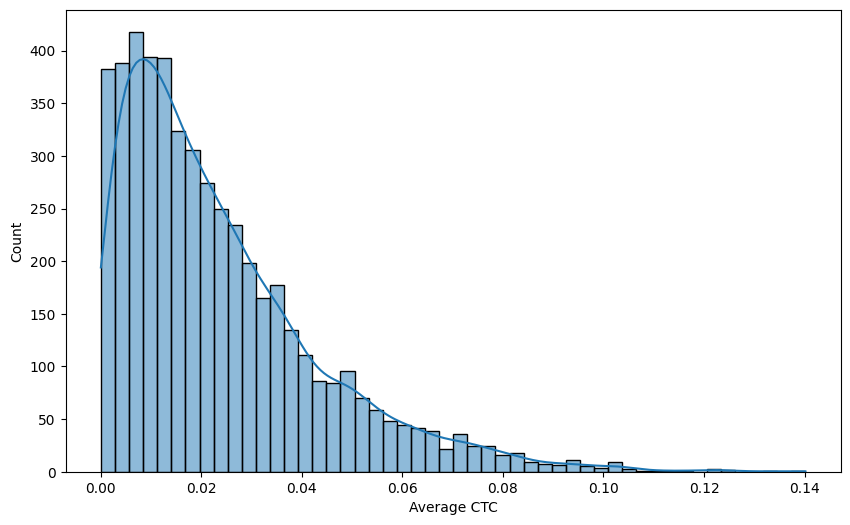

In [ ]:
#Simulating click to conversion rates for all marketing channels
random.seed(3101)
#Email
desired_mean = 0.047
size = len(customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
customers['Email CTC'] = data
#Display ad
desired_mean = 0.02
size = len(customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
customers['Display Ad CTC'] = data
#Video ad
desired_mean = 0.01
size = len(customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
customers['Video Ad CTC'] = data
#Search Engine Ad
desired_mean = 0.025
size = len(customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
customers['Search Engine Ad CTC'] = data
#Social media ad
desired_mean = 0.015
size = len(customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
customers['Social Media Ad CTC'] = data
#Average
customers['Average CTC'] = (customers['Email CTC'] + customers['Display Ad CTC'] + customers['Video Ad CTC'] + customers['Search Engine Ad CTC'] + customers['Social Media Ad CTC'])/5
print(customers['Average CTC'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(customers['Average CTC'], kde=True)

In [ ]:
# Setting some of the CTC rates to 0

customers['Email CTC'] = customers['Email CTC'].where(customers['Email CTC'] >= 0.02, 0)                                      #2%
customers['Display Ad CTC'] = customers['Display Ad CTC'].where(customers['Display Ad CTC'] >= 0.01, 0)                       #1%
customers['Video Ad CTC'] = customers['Video Ad CTC'].where(customers['Video Ad CTC'] >= 0.005, 0)                            #0.05%
customers['Search Engine Ad CTC'] = customers['Search Engine Ad CTC'].where(customers['Search Engine Ad CTC'] >= 0.02, 0)     #2%
customers['Social Media Ad CTC'] = customers['Social Media Ad CTC'].where(customers['Social Media Ad CTC'] >= 0.01, 0)        #1%
customers['Average CTC'] = customers['Average CTC'].where(customers['Average CTC'] >= 0.02, 0)                                #2%

## Paid for express shipping

In [ ]:
## All Prime members will have Express Shipping == 1
np.random.seed(42)

p_temp = purchases[purchases['Prime'] == 0]
p_temp = p_temp[['Survey ResponseID', 'Order Date']].drop_duplicates()
p_temp_count = len(p_temp)
temp = np.random.binomial(1, 0.47, size = p_temp_count)
p_temp['Express Shipping'] = temp

purchases = pd.merge(purchases, p_temp, on=['Survey ResponseID', 'Order Date'], how='left')
purchases['Express Shipping'] = purchases['Express Shipping'].fillna(1).astype(int)
purchases.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts,Express Shipping
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,0.00,1
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,0.15,1
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,0.00,1
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,0.00,1
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,0.00,1


In [ ]:
express_cust = (
    purchases[purchases['Express Shipping'] == 1]
    .drop_duplicates(subset=['Survey ResponseID', 'Order Date'])
    .groupby('Survey ResponseID')
    .size()
    .reset_index(name='num_express')
)
express_cust.head()

,Survey ResponseID,num_express
0,R_01vNIayewjIIKMF,5
1,R_037XK72IZBJyF69,67
2,R_03aEbghUILs9NxD,14
3,R_06RZP9pS7kONINr,132
4,R_06d9ULxrBmkwSTn,62


In [ ]:
all_cust = (
    purchases.drop_duplicates(subset=['Survey ResponseID', 'Order Date'])
    .groupby('Survey ResponseID')
    .size()
    .reset_index(name='num_express_all')
)
all_cust.head()

,Survey ResponseID,num_express_all
0,R_01vNIayewjIIKMF,5
1,R_037XK72IZBJyF69,160
2,R_03aEbghUILs9NxD,14
3,R_06RZP9pS7kONINr,132
4,R_06d9ULxrBmkwSTn,62


In [ ]:
exp_ship = pd.merge(all_cust, express_cust, on='Survey ResponseID', how='left')
exp_ship['Express Shipping'] = exp_ship['num_express'] / exp_ship['num_express_all']
exp_ship.head()

customers = pd.merge(customers, exp_ship[['Survey ResponseID', 'Express Shipping']], on='Survey ResponseID', how='left')
customers.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping
0,R_01vNIayewjIIKMF,1,1,0.000000,0.062692,0.000000,0.089971,0.000000,0.030794,1.00000
1,R_037XK72IZBJyF69,0,0,0.116243,0.000000,0.000000,0.000000,0.000000,0.024022,0.41875
2,R_03aEbghUILs9NxD,1,1,0.000000,0.030724,0.000000,0.000000,0.000000,0.000000,1.00000
3,R_06RZP9pS7kONINr,1,1,0.224220,0.000000,0.146967,0.000000,0.198426,0.113970,1.00000
4,R_06d9ULxrBmkwSTn,1,1,0.287938,0.000000,0.000000,0.081255,0.014923,0.078000,1.00000


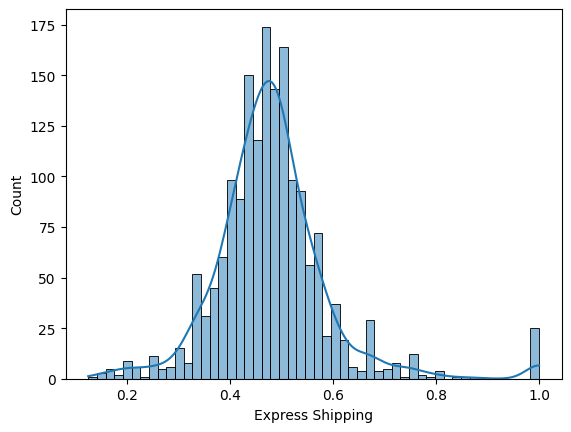

In [ ]:
sns.histplot(customers[customers['Prime'] == 0]['Express Shipping'], kde = True)
plt.show()

## Pre- tagging of customers

In [ ]:
num_to_sample_25 = int(len(customers) * 0.25)
print(num_to_sample_25)
num_to_sample_45 = int(len(customers) * 0.45)
print(num_to_sample_45)

1230
2215


In [ ]:
# Getting the impulse customers (45%)
impulse = event_goers.sample(n = num_to_sample_45, random_state=11)
impulse = customers[customers['Survey ResponseID'].isin(impulse['Survey ResponseID'])]
impulse_id = impulse['Survey ResponseID'].tolist()

# Getting the indecisive customers (25%)
non_impulse = customers[~customers['Survey ResponseID'].isin(impulse_id)].sample(n=num_to_sample_25, random_state=11)
non_impulse_id = non_impulse['Survey ResponseID'].tolist()

# Getting the remaining normal customers
remaining_customers = customers[~customers['Survey ResponseID'].isin(impulse_id + non_impulse_id)]

### Cart abandonment rate

In [ ]:
# for indecisive buyers
np.random.seed(42)
desired_mean = 0.85
size = len(non_impulse.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
non_impulse['Cart Abandonment Rate'] = data

In [ ]:
# for remaining buyers
np.random.seed(42)
desired_mean = 0.7

size = len(impulse.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
impulse['Cart Abandonment Rate'] = data

size = len(remaining_customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
remaining_customers['Cart Abandonment Rate'] = data

<ipython-input-64-6a47c47b2d1b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulse['Cart Abandonment Rate'] = data
<ipython-input-64-6a47c47b2d1b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_customers['Cart Abandonment Rate'] = data


<Axes: xlabel='Cart Abandonment Rate', ylabel='Count'>

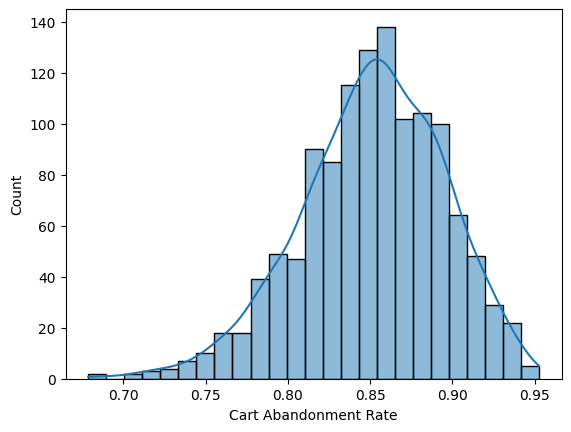

In [ ]:
sns.histplot(non_impulse['Cart Abandonment Rate'], kde=True)

### Whether customer checks product reviews before purchasing

In [ ]:
# For impulse buyers
np.random.seed(42)
size = len(impulse.index)
p = 0.3      # probability of getting 1
data = np.random.choice([0, 1], size=size, p=[1-p, p])
impulse['Check Review'] = data

<ipython-input-66-ae6c270a8328>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulse['Check Review'] = data


In [ ]:
# For indecisive buyers
np.random.seed(42)
size = len(non_impulse.index)
p = 0.8      # probability of getting 1
data = np.random.choice([0, 1], size=size, p=[1-p, p])
non_impulse['Check Review'] = data

In [ ]:
# For remaining buyers
np.random.seed(42)
size = len(remaining_customers.index)
p = 0.6      # probability of getting 1
data = np.random.choice([0, 1], size=size, p=[1-p, p])
remaining_customers['Check Review'] = data

<ipython-input-68-841b8285eb03>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_customers['Check Review'] = data


<Axes: xlabel='Check Review', ylabel='Count'>

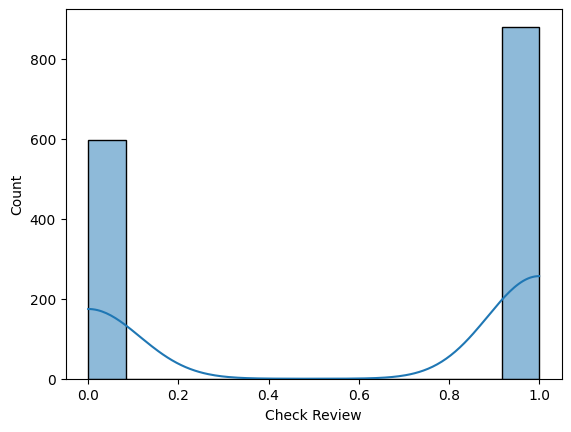

In [ ]:
sns.histplot(remaining_customers['Check Review'], kde=True)

### Return/refund rate

In [ ]:
# For impulse buyers
np.random.seed(42)
desired_mean = 0.2
size = len(impulse.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
impulse['Refund rate'] = data

impulse.head()

<ipython-input-70-1d7997a64600>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulse['Refund rate'] = data


,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate
2,R_03aEbghUILs9NxD,1,1,0.000000,0.030724,0.000000,0.000000,0.000000,0.000000,1.000000,0.733693,0,0.243994
3,R_06RZP9pS7kONINr,1,1,0.224220,0.000000,0.146967,0.000000,0.198426,0.113970,1.000000,0.709685,1,0.170417
6,R_085qq7w0pkhowox,0,1,0.000000,0.000000,0.000000,0.000000,0.012424,0.000000,0.557377,0.719513,1,0.306721
8,R_08uYA7fb4unHGkF,1,1,0.082589,0.000000,0.000000,0.126268,0.020301,0.045888,1.000000,0.645122,0,0.118960
13,R_0BrMxYYMHVMOBEJ,0,1,0.000000,0.016515,0.000000,0.220622,0.011220,0.049910,0.400000,0.832793,0,0.343723


In [ ]:
# For remaining buyers
np.random.seed(42)
desired_mean = 0.05

size = len(non_impulse.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
non_impulse['Refund rate'] = data

size = len(remaining_customers.index)
beta_param = 10
alpha_param = desired_mean * beta_param / (1 - desired_mean)
data = beta.rvs(alpha_param, beta_param, size=size)
remaining_customers['Refund rate'] = data

<ipython-input-71-46b332def645>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_customers['Refund rate'] = data


<Axes: xlabel='Refund rate', ylabel='Count'>

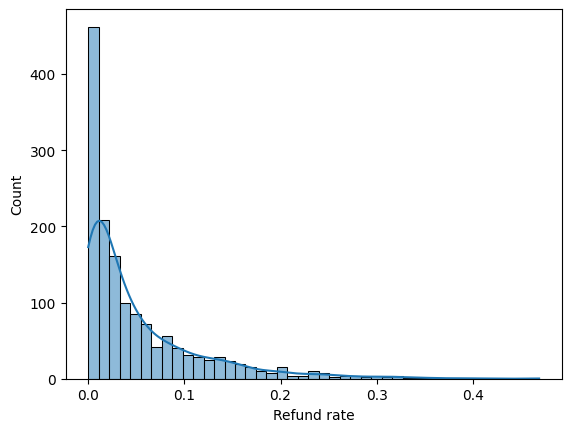

In [ ]:
sns.histplot(remaining_customers['Refund rate'], kde=True)

### Time in Cart

In [ ]:
# For impulse buyers
np.random.seed(42)
size = len(impulse.index)
data = np.random.exponential(scale=15, size=size) #average time = 15
impulse['Time in Cart'] = data

<ipython-input-73-04b163a7f1e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulse['Time in Cart'] = data


In [ ]:
# For indecisive buyers
np.random.seed(42)
size = len(non_impulse.index)
data = np.random.exponential(scale=35, size=size) #average time = 35
non_impulse['Time in Cart'] = data

In [ ]:
# For remaining buyers
np.random.seed(42)
size = len(remaining_customers.index)
data = np.random.exponential(scale=25, size=size) #average time = 25
remaining_customers['Time in Cart'] = data

<ipython-input-75-ed14c78009ae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_customers['Time in Cart'] = data


<Axes: xlabel='Time in Cart', ylabel='Count'>

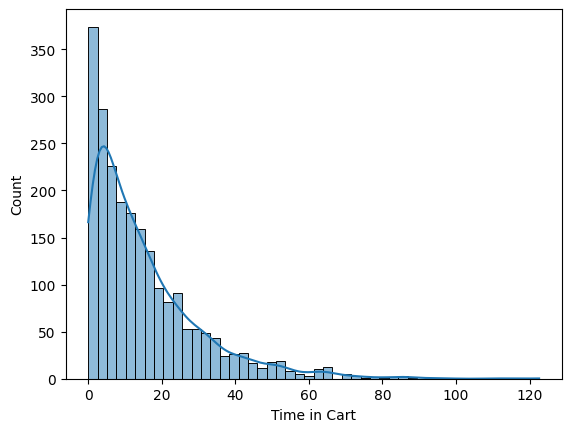

In [ ]:
sns.histplot(impulse['Time in Cart'], kde=True)

### Time on Page

In [ ]:
# For impulse buyers
np.random.seed(42)
size = len(impulse.index)
data = np.random.exponential(scale=1, size=size) #average time = 1
impulse['Time on Page'] = data

<ipython-input-77-01faf6344a85>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulse['Time on Page'] = data


In [ ]:
# For indecisive buyers
np.random.seed(42)
size = len(non_impulse.index)
data = np.random.exponential(scale=10, size=size) #average time = 10
non_impulse['Time on Page'] = data

In [ ]:
# For remaining buyers
np.random.seed(42)
size = len(remaining_customers.index)
data = np.random.exponential(scale=5, size=size) #average time = 5
remaining_customers['Time on Page'] = data

<ipython-input-79-30eab97ed18a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_customers['Time on Page'] = data


<Axes: xlabel='Time on Page', ylabel='Count'>

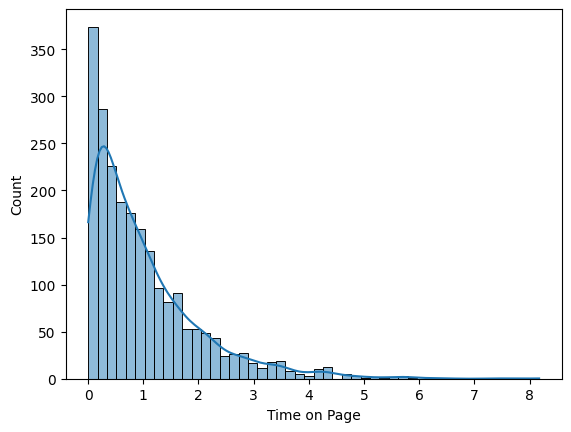

In [ ]:
sns.histplot(impulse['Time on Page'], kde=True)

## Combining columns together

In [ ]:
impulse.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page
2,R_03aEbghUILs9NxD,1,1,0.000000,0.030724,0.000000,0.000000,0.000000,0.000000,1.000000,0.733693,0,0.243994,7.039021,0.469268
3,R_06RZP9pS7kONINr,1,1,0.224220,0.000000,0.146967,0.000000,0.198426,0.113970,1.000000,0.709685,1,0.170417,45.151821,3.010121
6,R_085qq7w0pkhowox,0,1,0.000000,0.000000,0.000000,0.000000,0.012424,0.000000,0.557377,0.719513,1,0.306721,19.751185,1.316746
8,R_08uYA7fb4unHGkF,1,1,0.082589,0.000000,0.000000,0.126268,0.020301,0.045888,1.000000,0.645122,0,0.118960,13.694138,0.912943
13,R_0BrMxYYMHVMOBEJ,0,1,0.000000,0.016515,0.000000,0.220622,0.011220,0.049910,0.400000,0.832793,0,0.343723,2.544373,0.169625


In [ ]:
non_impulse.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page
3277,R_3h3K9E1W2YcQhhk,0,0,0.109353,0.0,0.0,0.000000,0.000000,0.023230,0.368421,0.866790,1,0.012920,16.424383,4.692681
3943,R_BzVyOXYGcejjaLv,1,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.859061,1,0.001922,105.354250,30.101214
1935,R_2ZIHUKwXYNXR0DI,1,1,0.080910,0.0,0.0,0.167813,0.000000,0.049861,1.000000,0.849253,1,0.046386,46.086099,13.167457
2163,R_2foDWbM9hrc4GlL,1,1,0.000000,0.0,0.0,0.000000,0.060601,0.000000,1.000000,0.821973,1,0.003468,31.952989,9.129426
2538,R_30v4IsTwlZaxIiR,0,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.488000,0.922968,0,0.028782,5.936870,1.696249


In [ ]:
remaining_customers.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page
0,R_01vNIayewjIIKMF,1,1,0.000000,0.062692,0.0,0.089971,0.000000,0.030794,1.00,0.794183,0,0.020594,11.731702,2.346340
5,R_07oHvj3bLVVRCRb,0,1,0.000000,0.000000,0.0,0.076576,0.000000,0.000000,0.44,0.726215,1,0.008515,75.253036,15.050607
7,R_08tF4u5YMrmEJ4l,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.20,0.681246,1,0.199507,32.918642,6.583728
10,R_0Arj0ePpTnReV1v,1,1,0.039969,0.012545,0.0,0.000000,0.117547,0.036719,1.00,0.688861,1,0.156163,22.823564,4.564713
11,R_0BCm9hRP9iTI081,1,1,0.082678,0.000000,0.0,0.079747,0.000000,0.035758,1.00,0.723076,0,0.000668,4.240622,0.848124


In [ ]:
customers = pd.concat([impulse, non_impulse, remaining_customers], axis=0, ignore_index=True)
customers.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page
0,R_03aEbghUILs9NxD,1,1,0.000000,0.030724,0.000000,0.000000,0.000000,0.000000,1.000000,0.733693,0,0.243994,7.039021,0.469268
1,R_06RZP9pS7kONINr,1,1,0.224220,0.000000,0.146967,0.000000,0.198426,0.113970,1.000000,0.709685,1,0.170417,45.151821,3.010121
2,R_085qq7w0pkhowox,0,1,0.000000,0.000000,0.000000,0.000000,0.012424,0.000000,0.557377,0.719513,1,0.306721,19.751185,1.316746
3,R_08uYA7fb4unHGkF,1,1,0.082589,0.000000,0.000000,0.126268,0.020301,0.045888,1.000000,0.645122,0,0.118960,13.694138,0.912943
4,R_0BrMxYYMHVMOBEJ,0,1,0.000000,0.016515,0.000000,0.220622,0.011220,0.049910,0.400000,0.832793,0,0.343723,2.544373,0.169625


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4923 entries, 0 to 4922
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survey ResponseID      4923 non-null   object 
 1   Prime                  4923 non-null   int64  
 2   Free Trial             4923 non-null   int64  
 3   Email CTC              4923 non-null   float64
 4   Display Ad CTC         4923 non-null   float64
 5   Video Ad CTC           4923 non-null   float64
 6   Search Engine Ad CTC   4923 non-null   float64
 7   Social Media Ad CTC    4923 non-null   float64
 8   Average CTC            4923 non-null   float64
 9   Express Shipping       4896 non-null   float64
 10  Cart Abandonment Rate  4923 non-null   float64
 11  Check Review           4923 non-null   int64  
 12  Refund rate            4923 non-null   float64
 13  Time in Cart           4923 non-null   float64
 14  Time on Page           4923 non-null   float64
dtypes: f

In [ ]:
p = purchases.copy()

In [ ]:
p.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts,Express Shipping
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,0.00,1
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,0.15,1
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,0.00,1
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,0.00,1
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,0.00,1


##RFM Scores

<ipython-input-88-ef6df80c4464>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['Recency'] = purchases['Recency'].dt.days
<ipython-input-88-ef6df80c4464>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['Recency_category'] = np.select(conditions_recency, choices_R, default= 'Unknown')
<ipython-input-88-ef6df80c4464>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

RFM
333    902
332    194
331      7
323    185
322    573
321    169
313     10
312    150
311    788
233     63
232     18
231      2
223     14
222    117
221     48
213      2
212     63
211    760
133     35
132     13
123     19
122     62
121     25
113      1
112     40
111    663
Name: count, dtype: int64


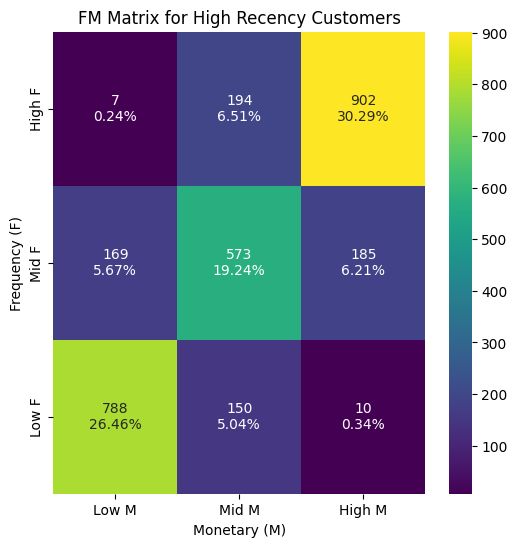

      Survey ResponseID  Prime  Free Trial  Email CTC  Display Ad CTC  \
0     R_03aEbghUILs9NxD      1           1   0.000000        0.030724   
1     R_06RZP9pS7kONINr      1           1   0.224220        0.000000   
2     R_085qq7w0pkhowox      0           1   0.000000        0.000000   
3     R_08uYA7fb4unHGkF      1           1   0.082589        0.000000   
4     R_0BrMxYYMHVMOBEJ      0           1   0.000000        0.016515   
...                 ...    ...         ...        ...             ...   
4918  R_z3emF7IfAc3UqYx      0           1   0.181365        0.000000   
4919  R_z6D1T2MULlDlLAB      1           1   0.038289        0.051589   
4920  R_z89cVoCKmGUboYN      0           0   0.000000        0.000000   
4921  R_z8w9TsEywvOcfCN      0           1   0.088078        0.107725   
4922  R_zfqnsBzlOAKibzb      1           1   0.027846        0.000000   

      Video Ad CTC  Search Engine Ad CTC  Social Media Ad CTC  Average CTC  \
0         0.000000              0.000000     

In [ ]:
#Lifetime RFM
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'], format='%Y-%m-%d')
purchases = purchases[purchases['Order Date'] < pd.to_datetime('2022-11-01', format='%Y-%m-%d')]
purchases['Year'] = purchases['Order Date'].dt.year
purchases['Month'] = purchases['Order Date'].dt.month
purchases['Recency'] = pd.to_datetime('2022-11-01', format='%Y-%m-%d') - purchases.groupby(['Survey ResponseID'])['Order Date'].transform("max")
purchases['Frequency'] = purchases.groupby(['Survey ResponseID'])['Order Date'].transform('nunique')
purchases['Order value'] = purchases['Quantity'] * purchases['Purchase Price Per Unit']
purchases['Monetary'] = purchases.groupby(['Survey ResponseID'])['Order value'].transform('sum')
purchases = purchases[['Recency','Frequency','Monetary','Survey ResponseID']]
purchases = purchases.drop_duplicates()

#purchases = purchases[['Recency','Frequency','Monetary','Survey ResponseID']]
#purchases = purchases.drop_duplicates()
purchases['Recency'] = purchases['Recency'].dt.days
#purchases['Recency'] = np.log(purchases['Recency'])
#Converting lifetime rfm to low,medium,high RFM
freq_medium = purchases['Frequency'].quantile(0.5)
freq_high = purchases['Frequency'].quantile(0.75)
monetary_medium = purchases['Monetary'].quantile(0.5)
monetary_high = purchases['Monetary'].quantile(0.75)
conditions_recency = [
    purchases['Recency'] <= 30,
    (purchases['Recency'] > 30) & (purchases['Recency'] <= 365),
    purchases['Recency'] > 365
]

conditions_frequency = [
    purchases['Frequency'] <= freq_medium,
    (purchases['Frequency'] > freq_medium) & (purchases['Frequency'] < freq_high),
    purchases['Frequency'] >= freq_high
]

conditions_monetary = [
    purchases['Monetary'] <= monetary_medium,
    (purchases['Monetary'] > monetary_medium) & (purchases['Monetary'] < monetary_high),
    purchases['Monetary'] >= monetary_high
]
choices_R = [3,2,1]
choices_FM = [1,2,3]
purchases['Recency_category'] = np.select(conditions_recency, choices_R, default= 'Unknown')
purchases['Frequency_category'] = np.select(conditions_frequency, choices_FM, default= 'Unknown')
purchases['Monetary_category'] = np.select(conditions_monetary, choices_FM, default= 'Unknown')
purchases['RFM'] = purchases['Recency_category'].astype(str) + purchases['Frequency_category'].astype(str) + purchases['Monetary_category'].astype(str)
print(purchases['RFM'].value_counts().sort_index(ascending= False))
lifetime_rfm = purchases[['Survey ResponseID','RFM']].drop_duplicates()
recency_3_data = purchases[purchases['Recency'] == 3]
fm_counts = [
    [sum(purchases['RFM'] == "331"), sum(purchases['RFM'] == "332"), sum(purchases['RFM'] == "333")],
    [sum(purchases['RFM'] == "321"), sum(purchases['RFM'] == "322"), sum(purchases['RFM'] == "323")],
    [sum(purchases['RFM'] == "311"), sum(purchases['RFM'] == "312"), sum(purchases['RFM'] == "313")]
]
fm_matrix = np.array(fm_counts)
total_count = fm_matrix.sum()
percentages = (fm_matrix / total_count * 100).round(2)
annot_labels = np.array([f"{count}\n{percent:.2f}%"
                         for count_row, percent_row in zip(fm_matrix, percentages)
                         for count, percent in zip(count_row, percent_row)]).reshape(fm_matrix.shape)

plt.figure(figsize=(6, 6))
sns.heatmap(fm_matrix, annot=annot_labels, fmt="", cmap="viridis",
            xticklabels=['Low M', 'Mid M', 'High M'],
            yticklabels=['High F', 'Mid F', 'Low F'])
plt.title("FM Matrix for High Recency Customers")
plt.xlabel("Monetary (M)")
plt.ylabel("Frequency (F)")
plt.show()
fig = px.scatter_3d(purchases, x='Recency', y='Frequency', z='Monetary',
                    color='Monetary', size = 'Recency',
                    labels={'Recency':'Recency', 'Frequency':'Frequency', 'Monetary':'Monetary'},
                    title="RFM 3D Scatter Plot")
fig.show()
#customers = customers.drop(columns=['RFM'])
customers = pd.merge(customers, lifetime_rfm, on='Survey ResponseID', how='inner')
print(customers)

##Saving dataframe

In [ ]:
#Saving to csv and customer df
print(customers)
customers.to_csv('customers.csv', index=False)
from google.colab import files
files.download("customers.csv")

      Survey ResponseID  Prime  Free Trial  Email CTC  Display Ad CTC  \
0     R_03aEbghUILs9NxD      1           1   0.000000        0.030724   
1     R_06RZP9pS7kONINr      1           1   0.224220        0.000000   
2     R_085qq7w0pkhowox      0           1   0.000000        0.000000   
3     R_08uYA7fb4unHGkF      1           1   0.082589        0.000000   
4     R_0BrMxYYMHVMOBEJ      0           1   0.000000        0.016515   
...                 ...    ...         ...        ...             ...   
4918  R_z3emF7IfAc3UqYx      0           1   0.181365        0.000000   
4919  R_z6D1T2MULlDlLAB      1           1   0.038289        0.051589   
4920  R_z89cVoCKmGUboYN      0           0   0.000000        0.000000   
4921  R_z8w9TsEywvOcfCN      0           1   0.088078        0.107725   
4922  R_zfqnsBzlOAKibzb      1           1   0.027846        0.000000   

      Video Ad CTC  Search Engine Ad CTC  Social Media Ad CTC  Average CTC  \
0         0.000000              0.000000     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(p)
p.to_csv('p.csv', index=False)
from google.colab import files
files.download("p.csv")

        Order Date  Purchase Price Per Unit  Quantity Shipping Address State  \
0       2018-12-04                     7.98         1                     NJ   
1       2018-12-22                    13.99         1                     NJ   
2       2018-12-24                     8.99         1                     NJ   
3       2018-12-25                    10.45         1                     NJ   
4       2018-12-25                    10.00         1                     NJ   
...            ...                      ...       ...                    ...   
1530758 2019-06-07                    16.80         1                     MA   
1530759 2019-08-14                     7.97         1                     MA   
1530760 2019-09-30                     6.68         1                     MA   
1530761 2019-10-13                    16.90         1                     MA   
1530762 2020-01-12                     3.77         7                     MA   

                                       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>